In [1]:
import os
import pandas as pd
import numpy as np
import re
import pickle as pkl
import matplotlib.pyplot as plt
from statistics import mean
import plotly.express as px
import plotly.graph_objects as go

regex = re.compile('.*NDI*$')
folder = os.path.join('ndi_servo_video', '2022-05-26')
demos = sorted(os.listdir(folder))
gripper_data = {}
open_close_data = {}
for demo in demos[1:]:
    demo_folder = os.path.join(folder, demo)
    file_set = sorted(os.listdir(demo_folder))
    for file in file_set:
        file_path = os.path.join(demo_folder, file)
        if "NDI" in file:
            gripper_data[demo] = pd.read_csv(file_path)
        elif "displacement_postprocessed" in file:
            open_close_data[demo] = pd.read_csv(file_path)
        
#     file1, file2 = file_set
#     # with open(os.path.join(data_folder, data497, 'labeled_actions_new.pkl'), 'rb') as f:
#     #     label_actions = pkl.load(f)
#     # trajectory_file = os.path.join(data_folder, data497, 'obj_pose_trajectory_interpolated_median.h5')
#     # trajectory_dataset = pd.read_hdf(trajectory_file)
#     grip_file = os.path.join(instance_folder, file1)
#     state_file = os.path.join(instance_folder, file2)
#     grip_states = pd.read_csv(grip_file)
#     pos_states = pd.read_csv(state_file, index_col='Unnamed: 0')
#     dframe = attach_grip_states(pos_states, grip_states)
#     all_dfs.append(dframe)

In [2]:
# preprocessing and convert to speed
spd_data = {}
cut_data = {}
for demo in demos[1:]:
    df = gripper_data[demo]
    close_t, open_t = open_close_data[demo].iloc[0].Timestamp, open_close_data[demo].iloc[1].Timestamp
    spd_df = df.loc[df.Time < open_t].loc[close_t < df.Time]
    cut_data[demo] = spd_df.copy()
    temp = np.sqrt(np.square(pd.DataFrame(spd_df.loc[:, ['x','y','z']]).diff(1)).sum(axis=1, skipna=True))[1:]
    spd_data[demo] = np.array(temp)

In [3]:
demos

['.DS_Store',
 '297761',
 '435030',
 '463674',
 '463675',
 '463678',
 '505038',
 '505039',
 '636936',
 '636938',
 '636939',
 '636940']

In [4]:
# settings
tag_interval = 20
demo1 = demos[8]
demo2 = demos[1]

test_demo1, test_demo2 = spd_data[demo1], spd_data[demo2]
def dynamic_time_warp(data1, data2):
    len1, len2 = len(data1), len(data2)
    dtw = np.full((len1, len2), fill_value=float('inf'))
    dtw[0, 0] = 0
    for i in range(1, len1):
        for j in range(1, len2):
            cost = abs(data1[i] - data2[j])
            dtw[i,j] = cost + min([dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1]])
    index_match = []
    # backward matching
    cur_pair = [len1-1, len2-1]
    while cur_pair!=[0,0]:
        index_match.append(cur_pair.copy())
        min_pair_val = min([dtw[cur_pair[0]-1, cur_pair[1]], dtw[cur_pair[0], cur_pair[1]-1], dtw[cur_pair[0]-1, cur_pair[1]-1]])
        if dtw[cur_pair[0]-1, cur_pair[1]-1] <= min_pair_val:
            cur_pair[0] -= 1
            cur_pair[1] -= 1
        elif dtw[cur_pair[0], cur_pair[1]-1] <= min_pair_val:
            cur_pair[1] -= 1
        elif dtw[cur_pair[0]-1, cur_pair[1]] <= min_pair_val:
            cur_pair[0] -= 1
    index_match.reverse()
    return index_match

demo_warped = np.array(dynamic_time_warp(test_demo1, test_demo2))
len(demo_warped)

300

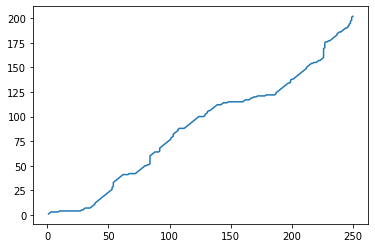

In [5]:
plt.plot(demo_warped[:, 0], demo_warped[:, 1])

Text(0.5, 1.0, 'Speed vs Time All Demos')

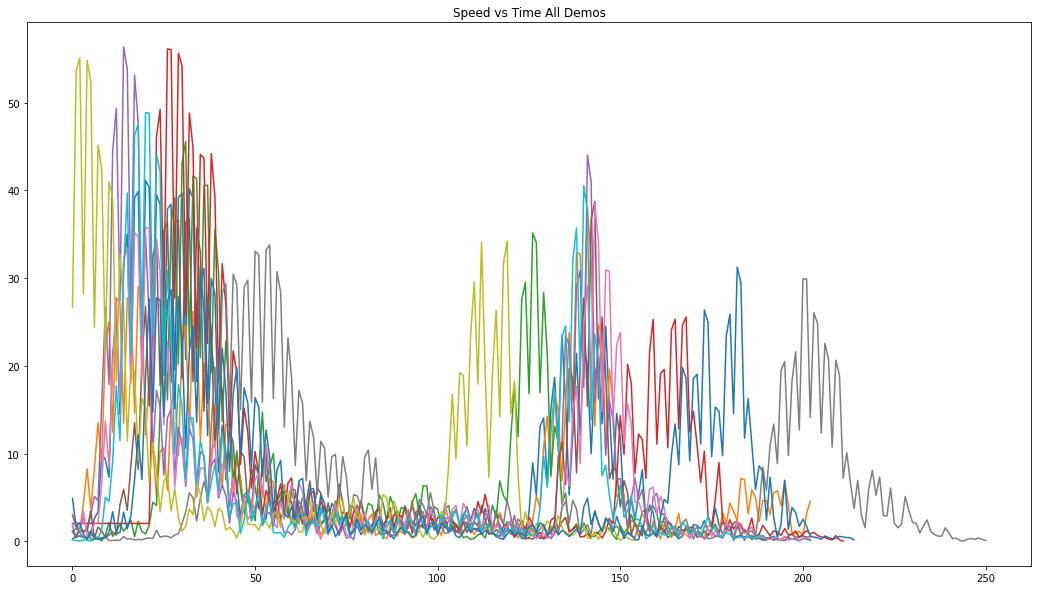

In [6]:
fig, ax0 = plt.subplots(nrows=1)
fig.set_figheight(10)
fig.set_figwidth(18)
for _, data in spd_data.items():
    data_len = len(data)
    ax0.plot(range(data_len), data)
ax0.set_title('Speed vs Time All Demos')

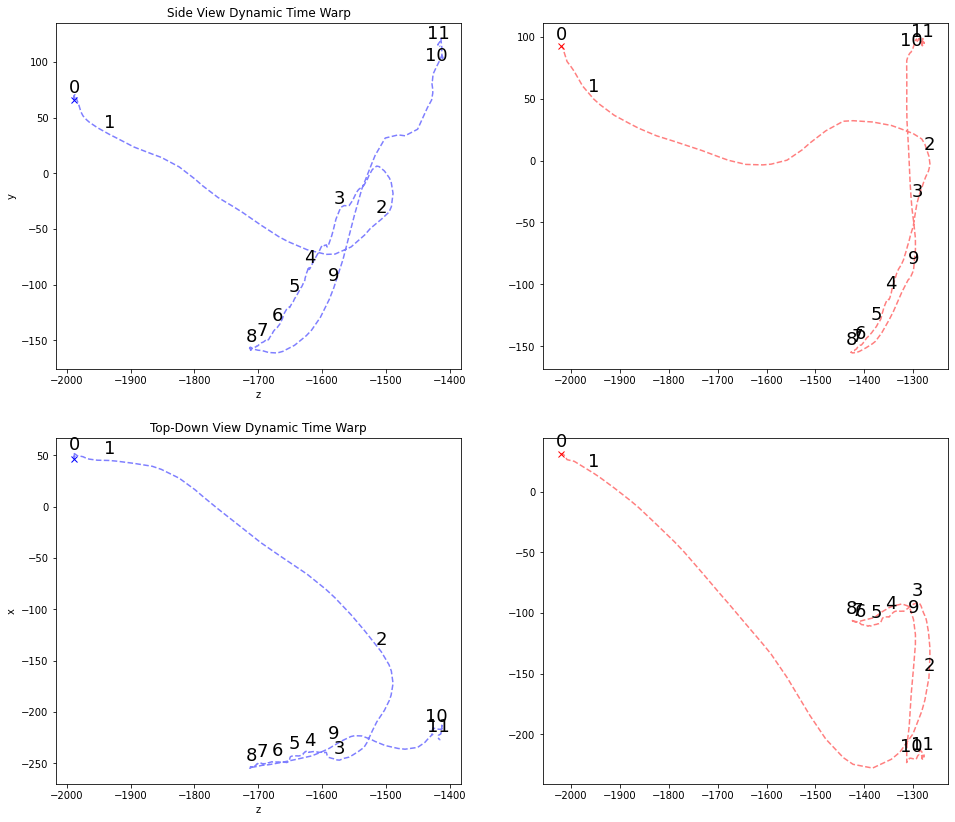

In [19]:

demo_df1 = cut_data[demo1].copy()
demo_df2 = cut_data[demo2].copy()

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(14)
fig.set_figwidth(16)

demo1_match, demo2_match = [], []
demo1_spd_match, demo2_spd_match = [], []
prev_index = 0
for i, match in enumerate(demo_warped):
    if match[0]%tag_interval==0 and match[0]!=prev_index:
        prev_index = match[0]
        demo1_match.append(demo_df1.iloc[match[0]][['x','y','z']])
        demo2_match.append(demo_df2.iloc[match[1]][['x','y','z']])
        demo1_spd_match.append([match[0], spd_data[demo1][match[0]]])
        demo2_spd_match.append([match[1], spd_data[demo2][match[1]]])
        
demo1_match = np.array(demo1_match)
demo2_match = np.array(demo2_match)
# plot gaussian product
ax1.plot(demo_df1['z'], demo_df1['x'],'--', color='blue', alpha=.5)
ax1.plot([demo_df1['z'].iloc[0]], [demo_df1['x'].iloc[0]],'x', color='blue')
ax2.plot(demo_df2['z'], demo_df2['x'],'--', color='red', alpha=.5)
ax2.plot([demo_df2['z'].iloc[0]], [demo_df2['x'].iloc[0]],'x', color='red')

ax3.plot(demo_df1['z'], demo_df1['y'],'--', color='blue', alpha=.5)
ax3.plot([demo_df1['z'].iloc[0]], [demo_df1['y'].iloc[0]],'x', color='blue')
ax4.plot(demo_df2['z'], demo_df2['y'],'--', color='red', alpha=.5)
ax4.plot([demo_df2['z'].iloc[0]], [demo_df2['y'].iloc[0]],'x', color='red')

ax1.set_xlabel('z')
ax1.set_ylabel('y')
ax1.set_title('Side View Dynamic Time Warp')

ax3.set_xlabel('z')
ax3.set_ylabel('x')
ax3.set_title('Top-Down View Dynamic Time Warp')

for i in range(len(demo1_match)):
    ax1.annotate('{}'.format(i),
    xy=demo1_match[i,[2, 0]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
     
    ax3.annotate('{}'.format(i),
    xy=demo1_match[i,[2, 1]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
       
    ax2.annotate('{}'.format(i),
    xy=demo2_match[i,[2, 0]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

    ax4.annotate('{}'.format(i),
    xy=demo2_match[i,[2, 1]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

Demos Length: 251, 203


/var/folders/sj/9v23364d24j7nx12j82tplmh0000gp/T/ipykernel_25347/3725997716.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  match_spd_loc1 = np.array((list(range(match_len)), demo1_spd_match))
/var/folders/sj/9v23364d24j7nx12j82tplmh0000gp/T/ipykernel_25347/3725997716.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  match_spd_loc2 = np.array((list(range(match_len)), demo2_spd_match))


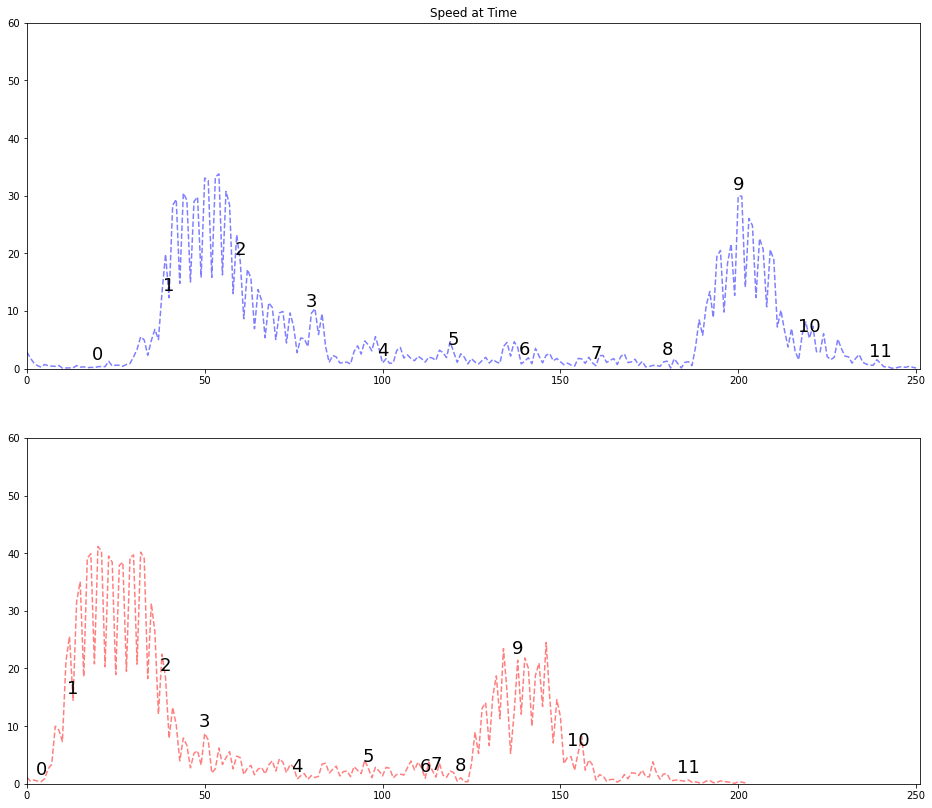

In [20]:
demo1_len = len(spd_data[demo1])
demo2_len = len(spd_data[demo2])
match_len = len(demo1_spd_match)


print('Demos Length: {}, {}'.format(demo1_len, demo2_len))
fig, (ax5, ax6) = plt.subplots(nrows=2)
fig.set_figheight(14)
fig.set_figwidth(16)
ax5.plot(range(demo1_len), spd_data[demo1],'--', color='blue', alpha=.5)
ax6.plot(range(demo2_len), spd_data[demo2],'--', color='red', alpha=.5)
ax5.set_title('Speed at Time')
ax5.set_ylim([0, 60])
ax6.set_ylim([0, 60])
ax5.set_xlim([0, max(demo1_len, demo2_len)])
ax6.set_xlim([0, max(demo1_len, demo2_len)])
match_spd_loc1 = np.array((list(range(match_len)), demo1_spd_match))
match_spd_loc2 = np.array((list(range(match_len)), demo2_spd_match))
for i in range(match_len):
    ax5.annotate('{}'.format(i),
    xy=demo1_spd_match[i],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
    
    ax6.annotate('{}'.format(i),
    xy=demo2_spd_match[i],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

In [9]:
target_demo = demos[8]
normalized_demos = {target_demo:spd_data[target_demo]}
for other_demo in demos[1:]:
    target_demo_spd, other_demo_spd = spd_data[target_demo], spd_data[other_demo]
    match_indices = np.array(dynamic_time_warp(target_demo_spd, other_demo_spd))
    new_demo = np.zeros(len(target_demo_spd))
    for match in match_indices:
        new_demo[match[0]-1] = other_demo_spd[match[1]-1]
    normalized_demos[other_demo] = new_demo

(0.0, 251.0)

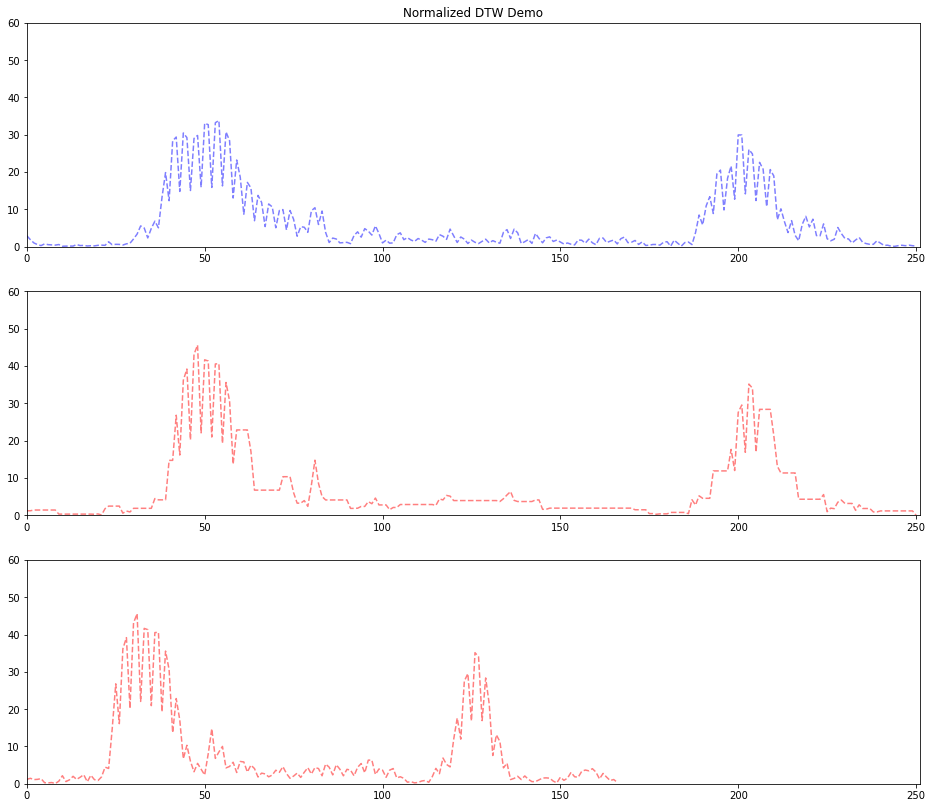

In [10]:
test_demo = demos[3]
target_demo_len = len(spd_data[target_demo])
orig_demo_len = len(spd_data[test_demo])

fig, (ax7, ax8, ax9) = plt.subplots(nrows=3)
fig.set_figheight(14)
fig.set_figwidth(16)
ax7.plot(range(target_demo_len), spd_data[target_demo],'--', color='blue', alpha=.5)
ax8.plot(range(target_demo_len), normalized_demos[test_demo],'--', color='red', alpha=.5)
ax9.plot(range(orig_demo_len), spd_data[test_demo],'--', color='red', alpha=.5)
ax7.set_title('Normalized DTW Demo')
ax7.set_ylim([0, 60])
ax8.set_ylim([0, 60])
ax9.set_ylim([0, 60])
ax7.set_xlim([0, max(target_demo_len, orig_demo_len)])
ax8.set_xlim([0, max(target_demo_len, orig_demo_len)])
ax9.set_xlim([0, max(target_demo_len, orig_demo_len)])

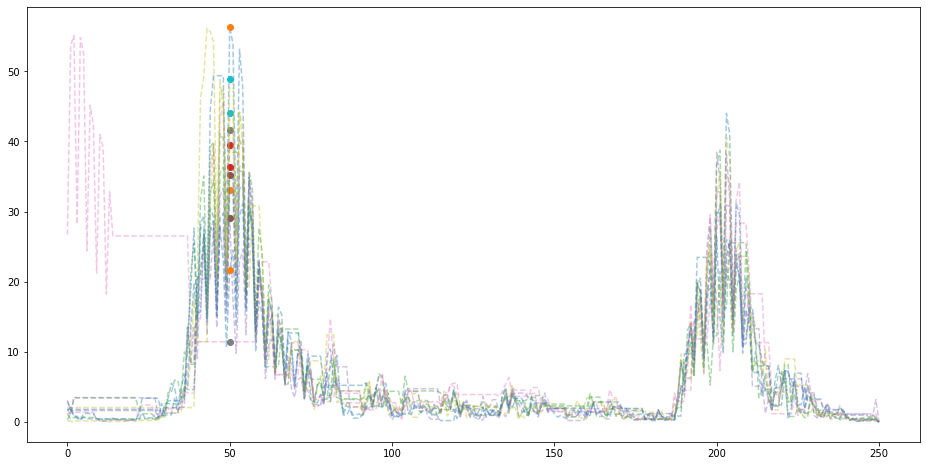

In [11]:
select_index = 50
fig, ax10 = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(16)
for _, norm_demo in normalized_demos.items():
    ax10.plot(range(len(norm_demo)), norm_demo, '--', alpha=.4)
    ax10.plot(select_index, norm_demo[select_index], 'o')